# Multi-Modal Surgery Pipeline with TOTALVI

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import anndata
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import scvi as scv
import pandas as pd

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Data loading and preprocessing

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [4]:
adata_ref = scv.data.pbmcs_10x_cite_seq(run_setup_anndata=False)

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                   
Downloading...: 24938it [00:00, 60700.38it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                    
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 63689.79it/s]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [5]:
adata_query = scv.data.dataset_10x("pbmc_10k_v3")
adata_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = adata_ref.obsm["protein_expression"]
data = np.zeros((adata_query.n_obs, pro_exp.shape[1]))
adata_query.obsm["protein_expression"] = pd.DataFrame(columns=pro_exp.columns, index=adata_query.obs_names, data = data)

INFO     Downloading file at data/10X/pbmc_10k_v3/filtered_feature_bc_matrix.h5              
Downloading...: 37492it [00:00, 69302.53it/s]                             


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now to concatenate the objects, which intersects the genes properly.

In [6]:
adata_full = anndata.concat([adata_ref, adata_query])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


And split them back up into reference and query (but now genes are properly aligned between objects).

In [7]:
adata_ref = adata_full[np.logical_or(adata_full.obs.batch == "PBMC5k", adata_full.obs.batch == "PBMC10k")].copy()
adata_query = adata_full[adata_full.obs.batch == "PBMC 10k (RNA only)"].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [8]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Finally, we use these selected genes for the query dataset as well.

In [9]:
adata_query = adata_query[:, adata_ref.var_names].copy()

## Create TOTALVI model and train it on CITE-seq reference dataset

In [10]:
sca.dataset.setup_anndata(
    adata_ref,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 10849 cells, 4000 vars, 2 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [11]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = sca.models.TOTALVI(
    adata_ref, 
    use_cuda=True, 
    **arches_params
)

In [12]:
vae_ref.train()

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO     Training for 400 epochs.                                                            
INFO     KL warmup for 8136.75 iterations                                                    
Training...: 100%|██████████| 400/400 [04:02<00:00,  1.65it/s]
INFO     Training time:  230 s. / 400 epochs                                                 


## Save Latent representation and visualize RNA data

In [13]:
adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

In [16]:
save_path = os.path.expanduser(f'~/Documents/totalvi/')
if not os.path.exists(save_path):
    os.makedirs(save_path)
adata_ref_c = adata_ref.copy()
adata_ref_c.obs["batch"] = adata_ref_c.obs["batch"].replace('PBMC5k','PBMC5k (CITE-seq, reference)')
adata_ref_c.obs["batch"] = adata_ref_c.obs["batch"].replace('PBMC10k','PBMC10k (CITE-seq, reference)')
sc.pl.umap(
    adata_ref_c,
    color=["batch"],
    frameon=False,
    palette=["#a6dcef","black","#00a8cc","red"],
    show=False,
    ncols=1,
)
plt.savefig(f"{save_path}ref_batch.pdf", bbox_inches='tight')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


In [17]:
vae_ref.model

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TOTALVAE(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4016, out_features=256, bias=True)
          (1): None
          (2): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.2, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=258, out_features=256, bias=True)
          (1): None
          (2): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4016, out_features=256, bias=True)
          (1): None
          (2): LayerNorm((25

## Save trained reference model

In [18]:
dir_path = "saved_model/"
vae_ref.save(dir_path, overwrite=True)

## Perform surgery on reference model and train on query dataset without protein data

In [19]:
vae_q = sca.models.TOTALVI.load_query_data(
    adata_query, 
    dir_path, 
    freeze_expression=True
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 11769 cells, 4000 vars, 3 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [20]:
vae_q.train(200, weight_decay=0.0)

INFO     Training for 200 epochs.                                                            
INFO     KL warmup for 8826.75 iterations                                                    
Training...:   0%|          | 0/200 [00:00<?, ?it/s]

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training...: 100%|██████████| 200/200 [02:59<00:00,  1.11it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  172 s. / 200 epochs                                                 


In [21]:
adata_query.obsm["X_totalVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(adata_query, use_rep="X_totalVI")
sc.tl.umap(adata_query, min_dist=0.4)

In [22]:
adata_query.obs["batch"] = adata_query.obs["batch"].replace('PBMC 10k (RNA only)','PBMC10k (RNA-seq, query)')

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


... storing 'batch' as categorical


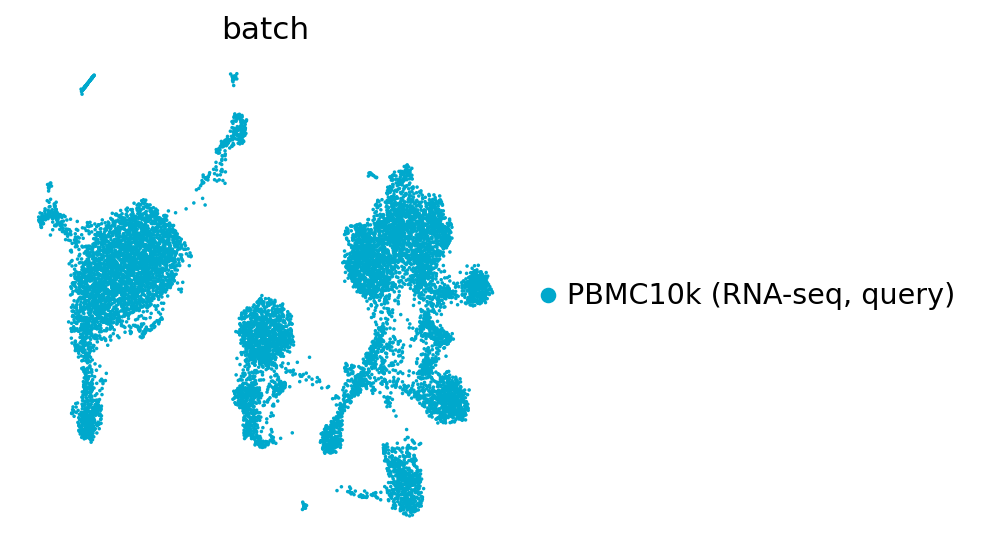

In [24]:
sc.pl.umap(
    adata_query,
    color=["batch"],
    frameon=False,
    palette=["#00a8cc"],
    show=False,
    ncols=1,
)
plt.savefig(f"{save_path}query_batch.pdf", bbox_inches='tight')

## Impute protein data for the query dataset and visualize

Impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [25]:
_, imputed_proteins = vae_q.get_normalized_expression(
    adata_query,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
adata_query.obs = pd.concat([adata_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    adata_query,
    color=imputed_proteins.columns,
    frameon=False,
    show=False,
    ncols=3,
)
plt.savefig(f"{save_path}imputed_proteins.pdf", bbox_inches='tight')

## Get latent representation of reference + query dataset and compute UMAP

In [29]:
adata_query.obs["batch"] = adata_query.obs["batch"].replace('PBMC10k (RNA-seq, query)','PBMC 10k (RNA only)')

In [30]:
adata_full_new = adata_query.concatenate(adata_ref, batch_key="none")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [31]:
adata_full_new.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_full_new)
sc.pp.neighbors(adata_full_new, use_rep="X_totalVI")
sc.tl.umap(adata_full_new, min_dist=0.3)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 22618 cells, 4000 vars, 3 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [32]:
_, imputed_proteins_all = vae_q.get_normalized_expression(
    adata_full_new,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for i, p in enumerate(imputed_proteins_all.columns):
    adata_full_new.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
adata_full_c = adata_full_new.copy()
adata_full_c.obs["batch"] = adata_full_c.obs["batch"].replace('PBMC5k','PBMC5k (CITE-seq, reference)')
adata_full_c.obs["batch"] = adata_full_c.obs["batch"].replace('PBMC10k','PBMC10k (CITE-seq, reference)')
adata_full_c.obs["batch"] = adata_full_c.obs["batch"].replace('PBMC 10k (RNA only)','PBMC10k (RNA-seq, query)')
perm_inds = np.random.permutation(np.arange(adata_full_c.n_obs))
sc.pl.umap(
    adata_full_c[perm_inds],
    color=["batch"],
    palette=["#a6dcef","black","#00a8cc","red"],
    frameon=False,
    show=False,
    ncols=1,
)
plt.savefig(f"{save_path}full_umap.pdf", bbox_inches='tight')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'batch' as categorical


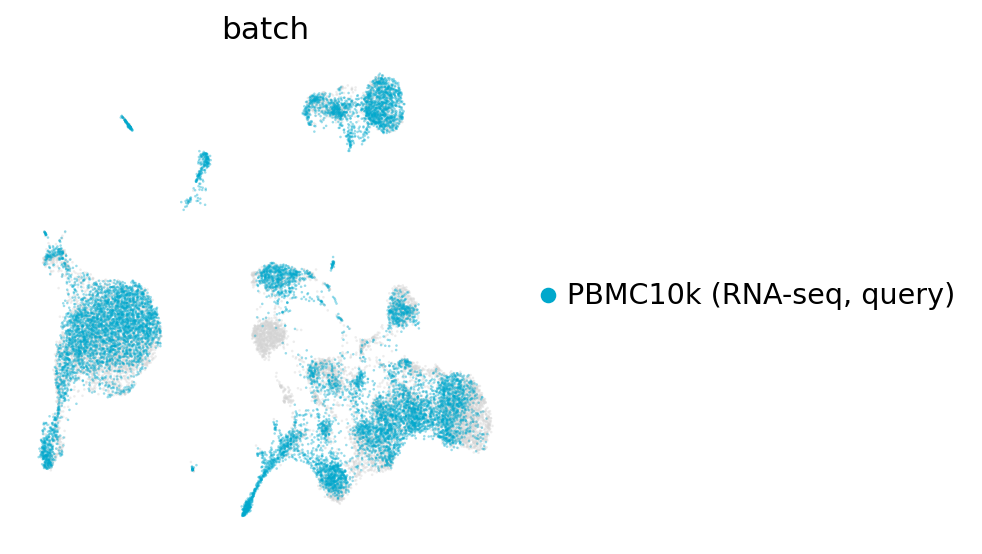

In [34]:
ax = sc.pl.umap(
    adata_full_c,
    color="batch",
    groups=["PBMC10k (RNA-seq, query)"],
    palette=["#a6dcef","black","#00a8cc","red"],
    frameon=False,
    ncols=1,
    show=False,
    alpha=0.4
)
plt.savefig(f"{save_path}full_grouped_umap.pdf", bbox_inches='tight')

/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


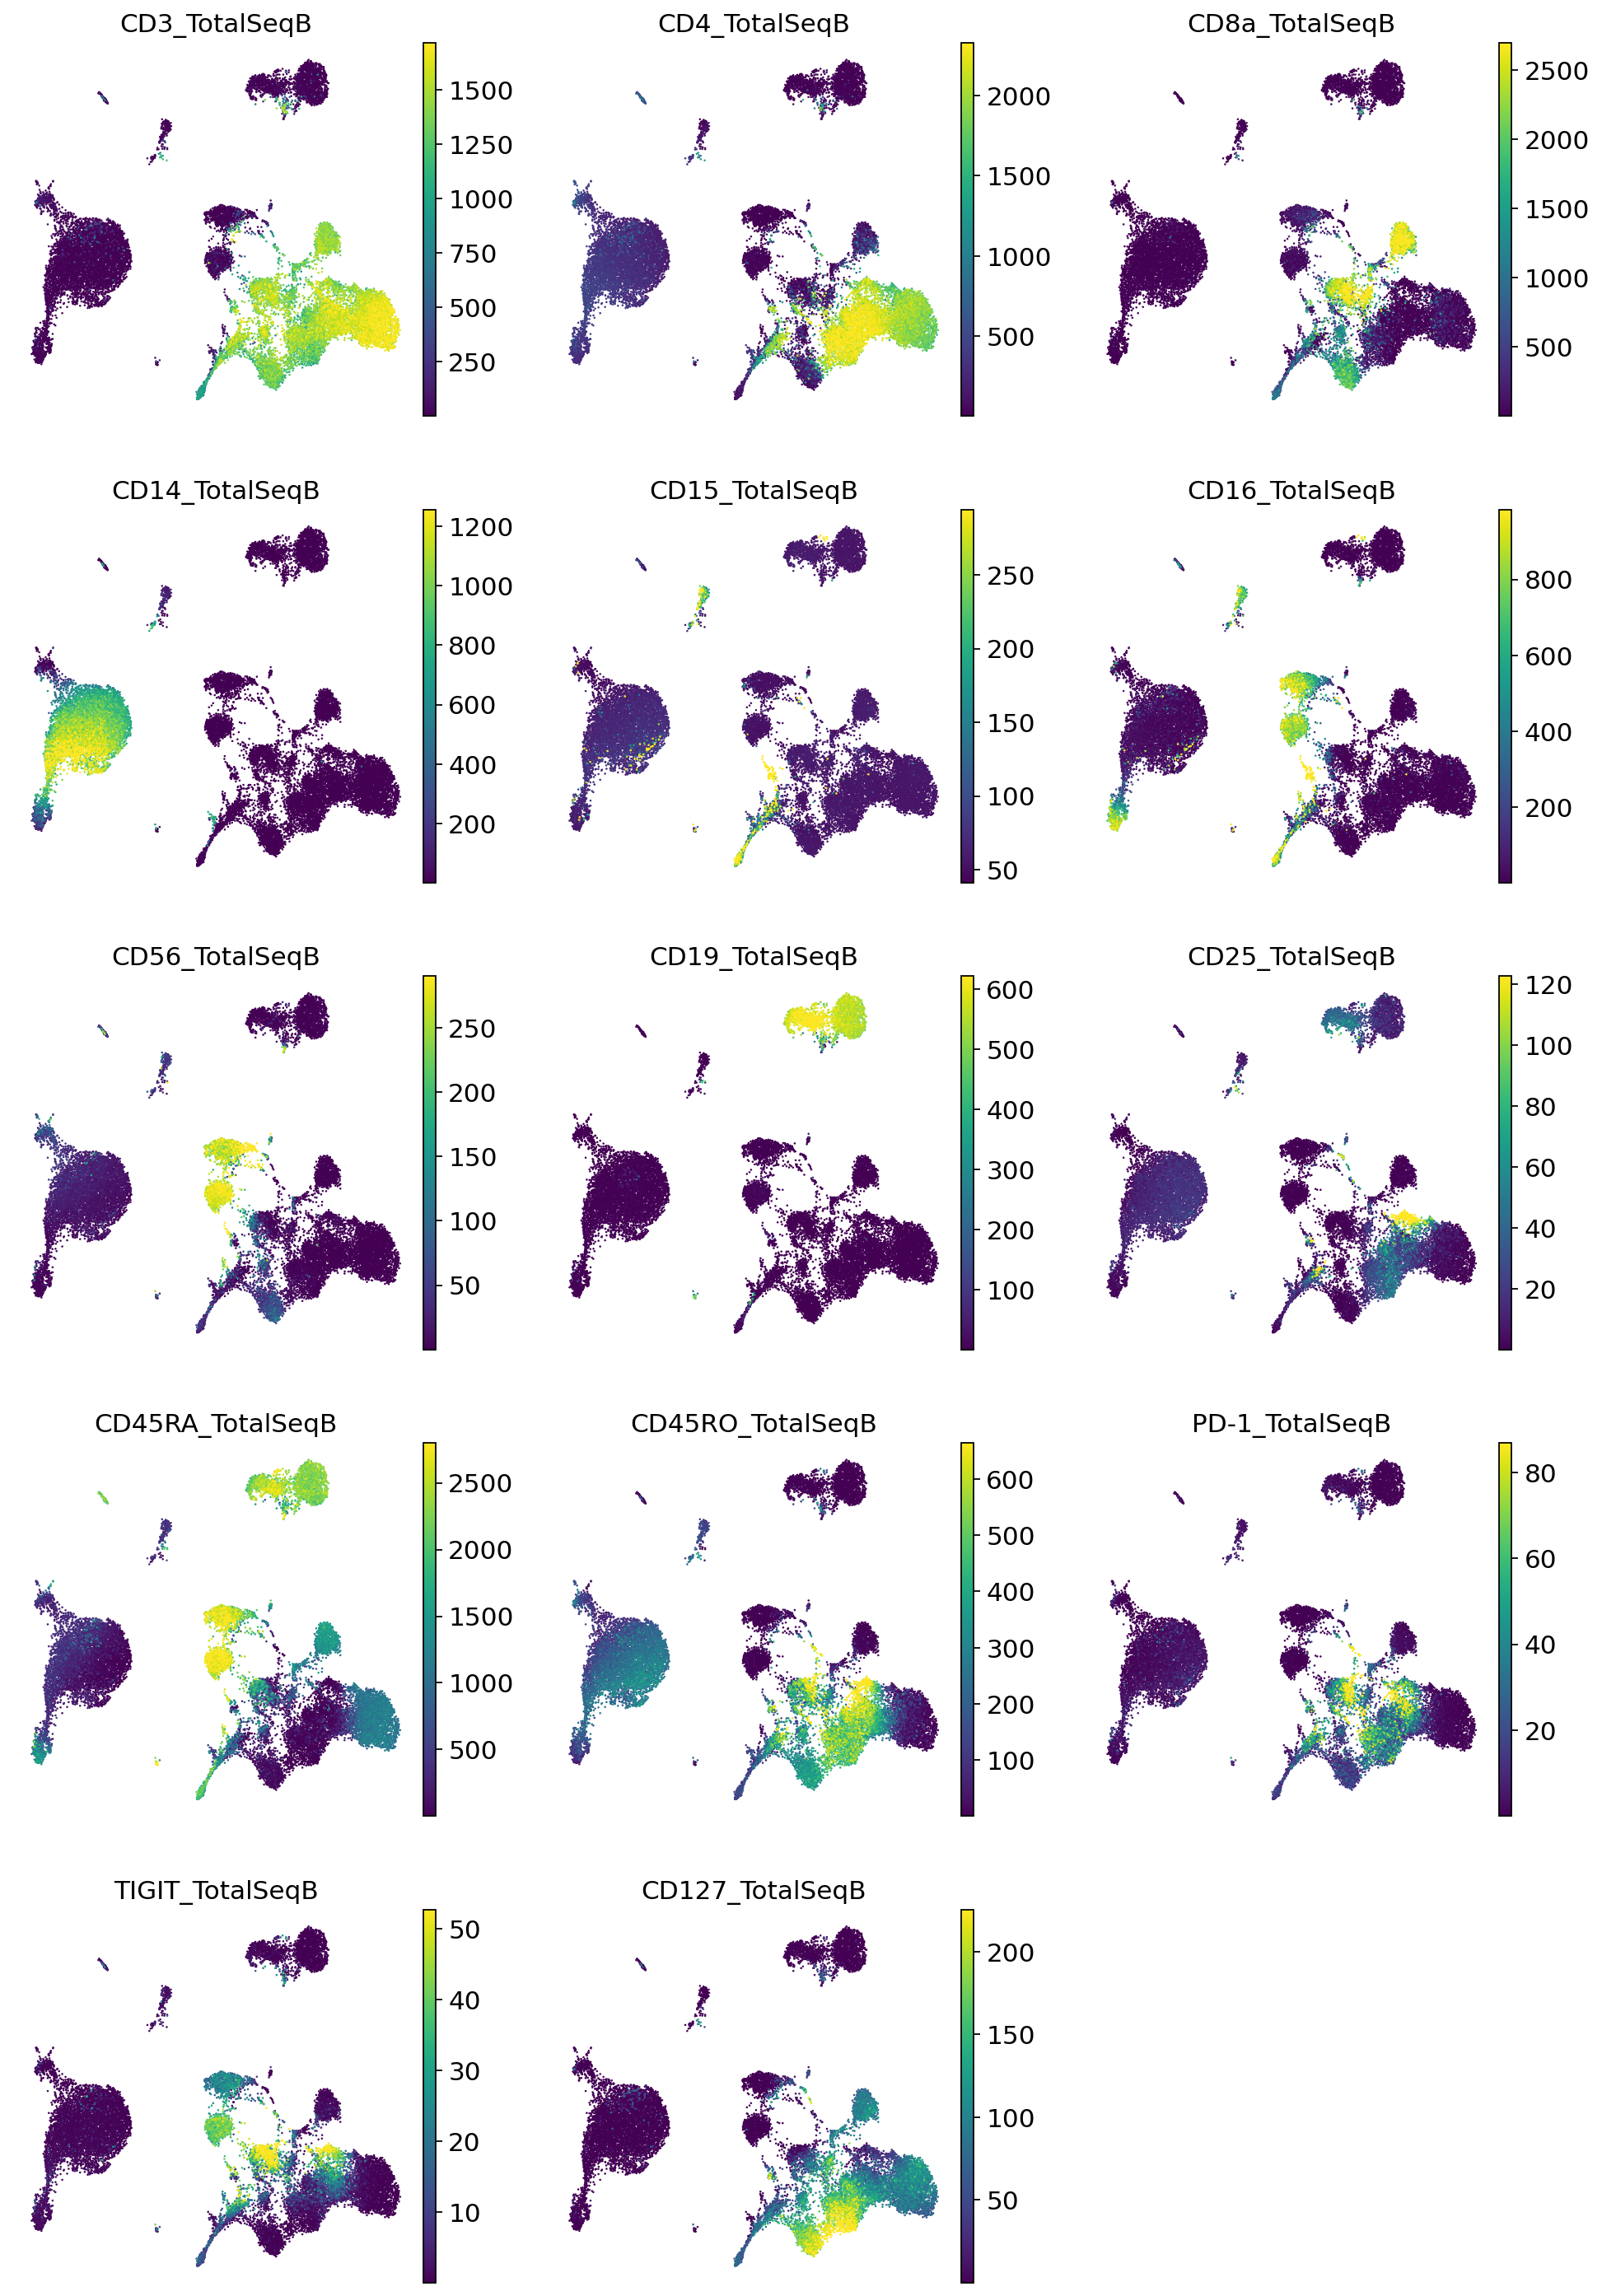

In [35]:
sc.pl.umap(
    adata_full_c,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    show=False,
    vmax="p99"
)
plt.savefig(f"{save_path}full_imputed_proteins.pdf", bbox_inches='tight')

In [ ]:
for name,p in vae_ref.model.named_parameters():
    for name_q, p_q in vae_q.model.named_parameters():
        if name_q == name:
            if not torch.equal(p, p_q):
                print(name)

In [ ]:
vae_ref.model.py_r.size()